In [1]:
!pip install torchsummary

## Importing The Libraries

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import torchvision

from torchsummary import summary
 
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Loading The Data

In [3]:
def cifar_dataloader():
    
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])

    
    # Input Data in Google Drive
    train_dataset = datasets.CIFAR10('/content/drive/MyDrive/All_Datasets/CIFAR10', train=True, download=True, transform=transform)
    
    test_dataset = datasets.CIFAR10('/content/drive/MyDrive/All_Datasets/CIFAR10', train=False, download=True, transform=transform)

    # Split dataset into training set and validation set.
    train_dataset, val_dataset = random_split(train_dataset, (45000, 5000))
    
    print("Image shape of a random sample image : {}".format(train_dataset[0][0].numpy().shape), end = '\n\n')
    
    print("Training Set:   {} images".format(len(train_dataset)))
    print("Validation Set:   {} images".format(len(val_dataset)))
    print("Test Set:       {} images".format(len(test_dataset)))
    
    BATCH_SIZE = 128

    # Generate dataloader
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    return train_loader, val_loader, test_loader

In [4]:
train_loader, val_loader, test_loader = cifar_dataloader()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/All_Datasets/CIFAR10/cifar-10-python.tar.gz to /content/drive/MyDrive/All_Datasets/CIFAR10
Files already downloaded and verified
Image shape of a random sample image : (3, 32, 32)

Training Set:   45000 images
Validation Set:   5000 images
Test Set:       10000 images


images.shape: torch.Size([128, 3, 32, 32])


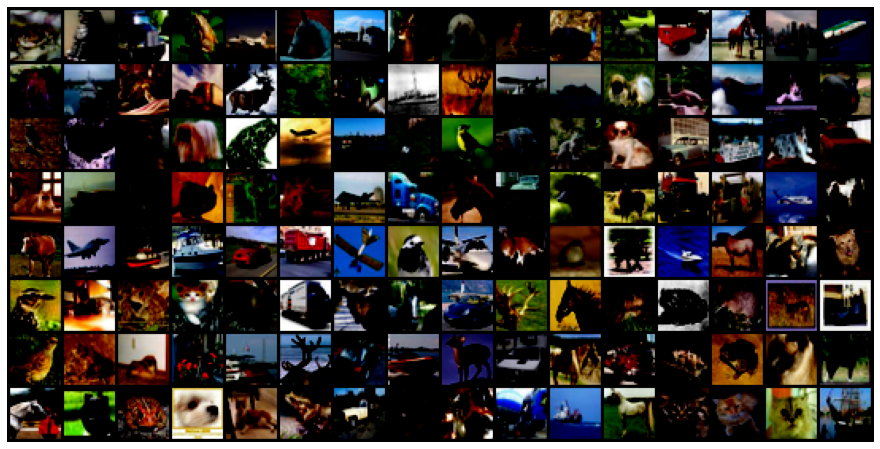

In [5]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## **Inception Network**

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

In [7]:
class Inception(nn.Module):
    def __init__(
        self,
        in_channels,
        num1x1,
        num3x3_reduce,
        num3x3,
        num5x5_reduce,
        num5x5,
        pool_proj,
    ):
        super(Inception, self).__init__()

        # Four output channel for each parallel block of network
        # Note, within Inception the individual blocks are running parallely
        # NOT sequentially.
        self.block1 = nn.Sequential(
            ConvBlock(in_channels, num1x1, kernel_size=1, stride=1, padding=0)
        )

        self.block2 = nn.Sequential(
            ConvBlock(in_channels, num3x3_reduce, kernel_size=1, stride=1, padding=0),
            ConvBlock(num3x3_reduce, num3x3, kernel_size=3, stride=1, padding=1),
        )

        self.block3 = nn.Sequential(
            ConvBlock(in_channels, num5x5_reduce, kernel_size=1, stride=1, padding=0),
            ConvBlock(num5x5_reduce, num5x5, kernel_size=5, stride=1, padding=2),
        )

        self.block4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1, ceil_mode=True),
            ConvBlock(in_channels, pool_proj, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x):
        # Note the different way this forward function
        # calculates the output.
        block1 = self.block1(x)
        block2 = self.block2(x)
        block3 = self.block3(x)
        block4 = self.block4(x)

        return torch.cat([block1, block2, block3, block4], 1)

In [8]:
class Auxiliary(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()

        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.activation = nn.ReLU()

        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.pool(x)

        out = self.conv(out)
        out = self.activation(out)
        # print('out shape is  ', out.shape)
        # out shape is  torch.Size([2, 128, 4, 4])

        out = torch.flatten(out, 1)

        out = self.fc1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)

        return out

In [9]:
class Inception_Network(nn.Module):
  def __init__(self, num_classes=10):
      super(Inception_Network, self).__init__()

      self.conv1 = ConvBlock(3, 64, kernel_size=7, stride=2, padding=3)
      self.pool1 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
      self.conv2 = ConvBlock(64, 64, kernel_size=1, stride=1, padding=0)
      self.conv3 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
      self.pool3 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)

      self.inception3A = Inception(
          in_channels=192,
          num1x1=64,
          num3x3_reduce=96,
          num3x3=128,
          num5x5_reduce=16,
          num5x5=32,
          pool_proj=32,
      )
      self.inception3B = Inception(
          in_channels=256,
          num1x1=128,
          num3x3_reduce=128,
          num3x3=192,
          num5x5_reduce=32,
          num5x5=96,
          pool_proj=64,
      )
      self.pool4 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)

      self.inception4A = Inception(
          in_channels=480,
          num1x1=192,
          num3x3_reduce=96,
          num3x3=208,
          num5x5_reduce=16,
          num5x5=48,
          pool_proj=64,
      )
      self.inception4B = Inception(
          in_channels=512,
          num1x1=160,
          num3x3_reduce=112,
          num3x3=224,
          num5x5_reduce=24,
          num5x5=64,
          pool_proj=64,
      )
      self.inception4C = Inception(
          in_channels=512,
          num1x1=128,
          num3x3_reduce=128,
          num3x3=256,
          num5x5_reduce=24,
          num5x5=64,
          pool_proj=64,
      )
      self.inception4D = Inception(
          in_channels=512,
          num1x1=112,
          num3x3_reduce=144,
          num3x3=288,
          num5x5_reduce=32,
          num5x5=64,
          pool_proj=64,
      )
      self.inception4E = Inception(
          in_channels=528,
          num1x1=256,
          num3x3_reduce=160,
          num3x3=320,
          num5x5_reduce=32,
          num5x5=128,
          pool_proj=128,
      )
      self.pool5 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)

      self.inception5A = Inception(
          in_channels=832,
          num1x1=256,
          num3x3_reduce=160,
          num3x3=320,
          num5x5_reduce=32,
          num5x5=128,
          pool_proj=128,
      )
      self.inception5B = Inception(
          in_channels=832,
          num1x1=384,
          num3x3_reduce=192,
          num3x3=384,
          num5x5_reduce=48,
          num5x5=128,
          pool_proj=128,
      )
      self.pool6 = nn.AdaptiveAvgPool2d((1, 1))

      self.dropout = nn.Dropout(0.4)
      self.fc = nn.Linear(1024, num_classes)

      self.aux4A = Auxiliary(512, num_classes)
      self.aux4D = Auxiliary(528, num_classes)

  def forward(self, x):
    out = self.conv1(x)
    out = self.pool1(out)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.pool3(out)
    out = self.inception3A(out)
    out = self.inception3B(out)
    out = self.pool4(out)
    out = self.inception4A(out)

    aux1 = self.aux4A(out)

    out = self.inception4B(out)
    out = self.inception4C(out)
    out = self.inception4D(out)

    aux2 = self.aux4D(out)

    out = self.inception4E(out)
    out = self.pool5(out)
    out = self.inception5A(out)
    out = self.inception5B(out)
    out = self.pool6(out)
    out = torch.flatten(out, 1)
    out = self.dropout(out)
    out = self.fc(out)

    return out, aux1, aux2

In [10]:
model = Inception_Network().to(device)
summary(model, (3, 96, 96))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,472
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         ConvBlock-4           [-1, 64, 48, 48]               0
         MaxPool2d-5           [-1, 64, 24, 24]               0
            Conv2d-6           [-1, 64, 24, 24]           4,160
       BatchNorm2d-7           [-1, 64, 24, 24]             128
              ReLU-8           [-1, 64, 24, 24]               0
         ConvBlock-9           [-1, 64, 24, 24]               0
           Conv2d-10          [-1, 192, 24, 24]         110,784
      BatchNorm2d-11          [-1, 192, 24, 24]             384
             ReLU-12          [-1, 192, 24, 24]               0
        ConvBlock-13          [-1, 192, 24, 24]               0
        MaxPool2d-14          [-1, 192,

## Training

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer):
    EPOCHS = 15
    train_samples_num = 45000
    val_samples_num = 5000

    train_epoch_loss_history, val_epoch_loss_history = [], []

    for epoch in range(EPOCHS):

        train_running_loss = 0
        correct_train = 0

        model.train().cuda()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            """ for every mini-batch during the training phase, we
            typically want to explicitly set the gradients
            to zero before starting to do backpropragation """
            optimizer.zero_grad()

            # Start the forward pass
            prediction0, aux_pred_1, aux_pred_2 = model(inputs)

            # Compute the loss.
            real_loss = criterion(prediction0, labels)
            aux_loss_1 = criterion(aux_pred_1, labels)
            aux_loss_2 = criterion(aux_pred_2, labels)

            loss = real_loss + 0.3 * aux_loss_1 + 0.3 * aux_loss_2

            # do backpropagation and update weights with step()# Backward pass.
            loss.backward()
            optimizer.step()

            # Update the running corrects
            _, predicted = torch.max(prediction0.data, 1)

            correct_train += (predicted == labels).float().sum().item()

            """ Compute batch loss
            multiply each average batch loss with batch-length.
            The batch-length is inputs.size(0) which gives the number total images in each batch.
            Essentially I am un-averaging the previously calculated Loss """
            train_running_loss += loss.data.item() * inputs.shape[0]

        train_epoch_loss = train_running_loss / train_samples_num

        train_epoch_loss_history.append(train_epoch_loss)

        train_acc = correct_train / train_samples_num

        val_loss = 0
        correct_val = 0

        model.eval().cuda()

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass.
                prediction0, aux_pred_1, aux_pred_2 = model(inputs)

                # Compute the loss.
                real_loss = criterion(prediction0, labels)
                aux_loss_1 = criterion(aux_pred_1, labels)
                aux_loss_2 = criterion(aux_pred_2, labels)

                loss = real_loss + 0.3 * aux_loss_1 + 0.3 * aux_loss_2

                # Compute training accuracy.
                _, predicted = torch.max(prediction0.data, 1)
                correct_val += (predicted == labels).float().sum().item()

                # Compute batch loss.
                val_loss += loss.data.item() * inputs.shape[0]

            val_loss /= val_samples_num
            val_epoch_loss_history.append(val_loss)
            val_acc = correct_val / val_samples_num

        info = "[For Epoch {}/{}]: train-loss = {:0.5f} | train-acc = {:0.3f} | val-loss = {:0.5f} | val-acc = {:0.3f}"

        print(
            info.format(
                epoch + 1, EPOCHS, train_epoch_loss, train_acc, val_loss, val_acc
            )
        )

    return train_epoch_loss_history, val_epoch_loss_history

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
train_epoch_loss_history, val_epoch_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer)

[For Epoch 1/15]: train-loss = 2.39388 | train-acc = 0.457 | val-loss = 2.21068 | val-acc = 0.517
[For Epoch 2/15]: train-loss = 1.72852 | train-acc = 0.626 | val-loss = 1.90704 | val-acc = 0.589
[For Epoch 3/15]: train-loss = 1.40314 | train-acc = 0.699 | val-loss = 1.45778 | val-acc = 0.694
[For Epoch 4/15]: train-loss = 1.17968 | train-acc = 0.750 | val-loss = 1.33321 | val-acc = 0.718
[For Epoch 5/15]: train-loss = 1.01862 | train-acc = 0.786 | val-loss = 1.32789 | val-acc = 0.729
[For Epoch 6/15]: train-loss = 0.88205 | train-acc = 0.815 | val-loss = 1.35354 | val-acc = 0.725
[For Epoch 7/15]: train-loss = 0.76263 | train-acc = 0.840 | val-loss = 1.44414 | val-acc = 0.722
[For Epoch 8/15]: train-loss = 0.66904 | train-acc = 0.860 | val-loss = 1.18518 | val-acc = 0.767
[For Epoch 9/15]: train-loss = 0.57368 | train-acc = 0.881 | val-loss = 1.31611 | val-acc = 0.753
[For Epoch 10/15]: train-loss = 0.50646 | train-acc = 0.896 | val-loss = 1.30890 | val-acc = 0.753
[For Epoch 11/15]: 

## Evaluation

In [14]:
num_test_samples = 10000
correct = 0 

model.eval().cuda()

with  torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Make predictions.
        prediction, _, _ = model(inputs)

        # Retrieve predictions indexes.
        _, predicted_class = torch.max(prediction.data, 1)

        # Compute number of correct predictions.
        correct += (predicted_class == labels).float().sum().item()

test_accuracy = correct / num_test_samples

print('Test accuracy: {}'.format(test_accuracy))

Test accuracy: 0.7561
